# Forest Fires - damaged area estimation

`Original approach in modeling by Cortez and Morias, 2007:`

source: http://archive.ics.uci.edu/ml/datasets/Forest+Fires

In the original paper the output 'area' was first transformed with a ln(x+1) function.
Then, several Data Mining methods were applied. After fitting the models, the outputs were
post-processed with the inverse of the ln(x+1) transform. Four different input setups were
used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
(REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
the SVM model predicts better small fires, which are the majority.

`Attribute information:`

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20: 
   - The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.
6. DMC - DMC index from the FWI system: 1.1 to 291.3
   - The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.
7. DC - DC index from the FWI system: 7.9 to 860.6
   - The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.
8. ISI - ISI index from the FWI system: 0.0 to 56.10
   - The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It is based on wind speed and FFMC. Like the rest of the FWI system components, ISI does not take fuel type into account. Actual spread rates vary between fuel types at the same ISI.
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. <b>area - the burned area of the forest (in ha): 0.00 to 1090.84</b>: target variable to predict

<span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#00b3e5;">  Structure of the FWI (Fire Weather Index) System
<br></span>
![alt text](fwi_structure.png "Fire Weather Index Structure")
source: https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi


## Steps:

 - Data loading and preprocessing
 - Exploratory Data Analysis, uni/bi-variate analysis
 - Feature Engineering
 - Model Selection and cross-validation
 - Model Tuning (grid and randomized searches)

# Data loading and preprocessing

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv("forestfires.csv")  # Read the data regarding dataset attributes
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
print(df.shape)

(517, 13)


In [5]:
df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [6]:
df.duplicated().sum()

4

In [7]:
print('Percent of duplicated entries is: ', df.duplicated().sum()/len(df)*100)

Percent of duplicated entries is:  0.7736943907156674


In [8]:
dupies=df[df.duplicated()]
dupies

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
53,4,3,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00
100,3,4,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00
215,4,4,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66
303,3,6,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00


`Considered as duplicated just because of one of values as the same as previous rows, when other values are different. So that not all of them are duplicated rows. Checking unique values`

In [9]:
dupies.nunique()

X        2
Y        3
month    3
day      4
FFMC     4
DMC      4
DC       4
ISI      4
temp     4
RH       4
wind     3
rain     1
area     2
dtype: int64

`Not realy duplicated, 4 unique values for most critical variables, should not be removed.`

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [12]:
df.nunique()

X          9
Y          7
month     12
day        7
FFMC     106
DMC      215
DC       219
ISI      119
temp     192
RH        75
wind      21
rain       7
area     251
dtype: int64

In [13]:
df.skew()

X        0.036246
Y        0.417296
FFMC    -6.575606
DMC      0.547498
DC      -1.100445
ISI      2.536325
temp    -0.331172
RH       0.862904
wind     0.571001
rain    19.816344
area    12.846934
dtype: float64

In [14]:
df['area'].value_counts(normalize=True)*100

0.00     47.775629
1.94      0.580271
3.71      0.386847
0.90      0.386847
1.95      0.386847
           ...    
1.26      0.193424
2.44      0.193424
2.03      0.193424
2.21      0.193424
24.24     0.193424
Name: area, Length: 251, dtype: float64

### Insights:

 - Data length is about 1000 entries, with 2.5% duplicates
 - Without NaN, negative or 'character' values, all are numeric (float or int)
 - Columns slag, ash, superplastic contain many zeros and non-normally distributed
 - age is skewed to the left
 - Output variable, strength, has the highest number of unique values

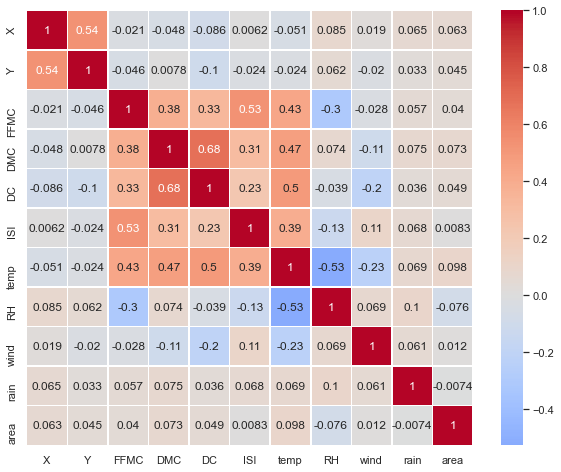

In [15]:
# Correlations heat map

sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=True,
            cmap="coolwarm")
plt.show()

### Insights:

 - XXX

<AxesSubplot:>

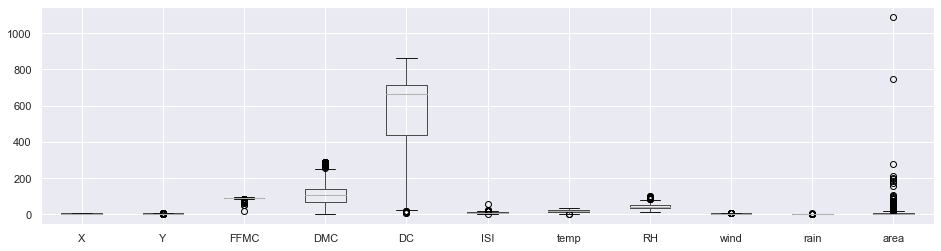

In [16]:
df.boxplot(figsize=(16,4))

<AxesSubplot:xlabel='area', ylabel='Count'>

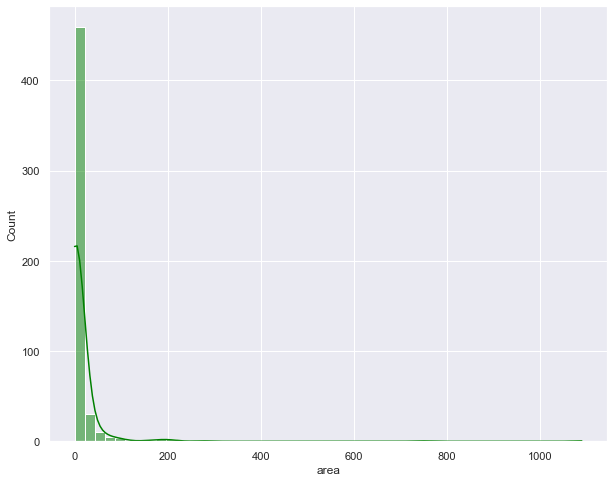

In [17]:
sns.histplot(df['area'], kde=True, bins=50, color='green')

### Insights:

 - cement, water, coarseagg, fineagg and strength look normally distributed, although water and strength have some outliers
 - slag, ash, superplastic are non-normally ditributed due to multiple zeros.
 - age should be log-transformed.

In [18]:
df['fire_yes_no']=df['area'].apply(lambda x: 1 if x>0 else 0)

/Users/innag/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


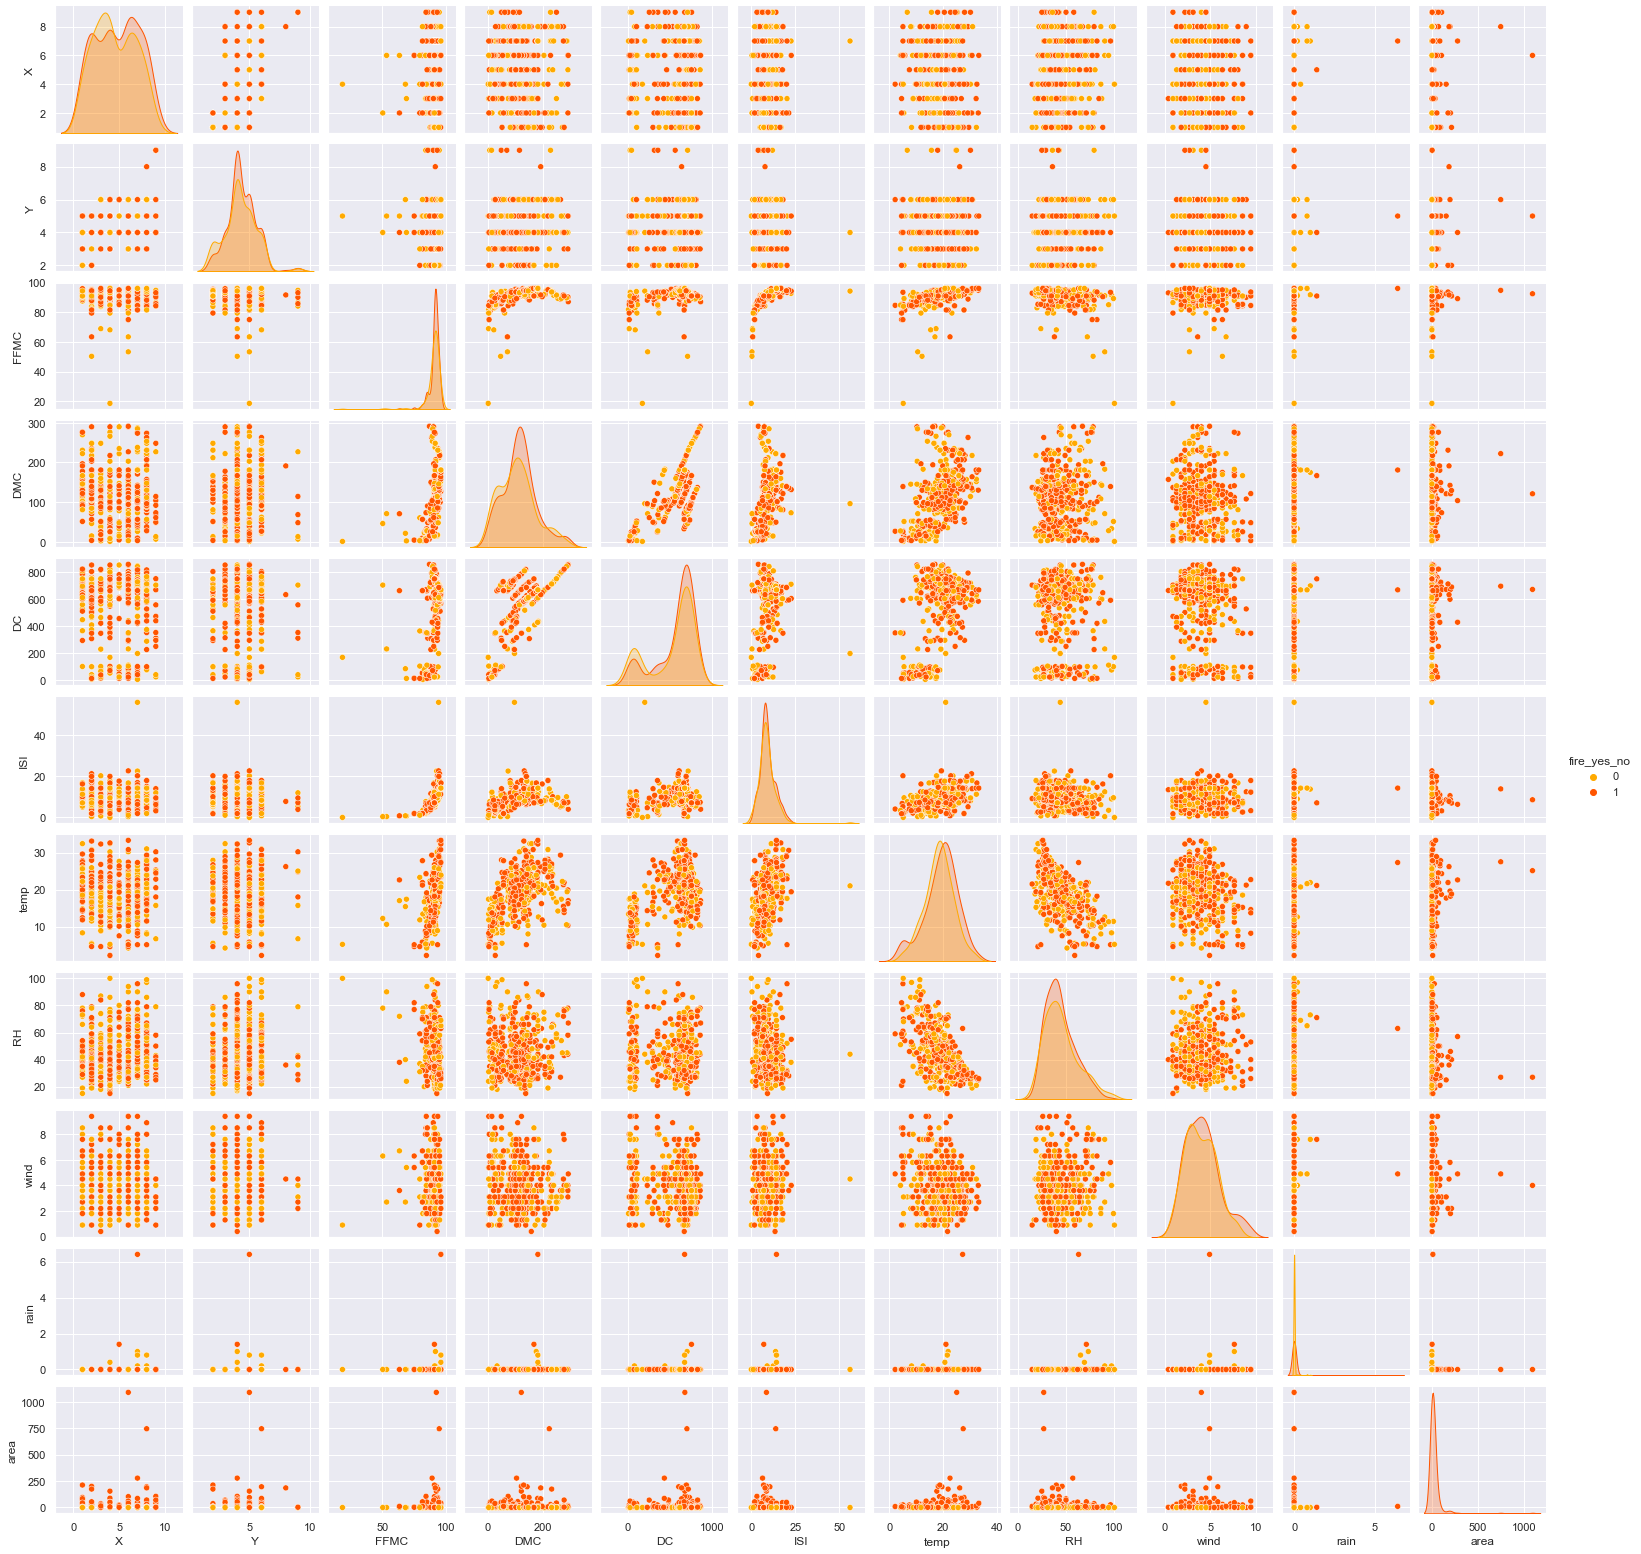

In [19]:
sns.pairplot(df, hue='fire_yes_no', height=2, aspect=1, palette='autumn_r')

In [20]:
df['fire_yes_no'].value_counts(normalize=True)*100

1    52.224371
0    47.775629
Name: fire_yes_no, dtype: float64

In [21]:
yes_fire=df.loc[df['area'] > 0]
no_fire=df.loc[df['area'] == 0]

print('data lengths with and without fired areas are: ', len(yes_fire), len(no_fire))

data lengths with and without fired areas are:  270 247


<AxesSubplot:xlabel='area', ylabel='Count'>

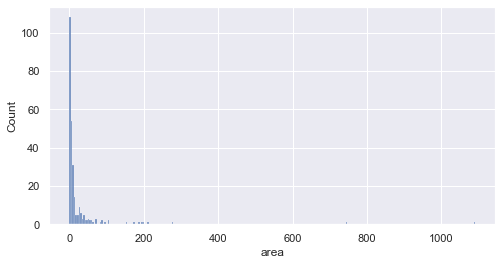

In [22]:
sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(data=yes_fire, x='area')

### Insights & Preprocessing Steps. 
1. EDA
2. Feature engineering

<AxesSubplot:xlabel='rain', ylabel='count'>

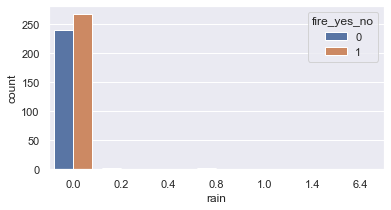

In [23]:
sns.set(rc={'figure.figsize':(6,3)})
sns.countplot(data=df, x='rain', hue='fire_yes_no')

In [24]:
df['rain'].value_counts()

0.0    509
0.8      2
0.2      2
0.4      1
6.4      1
1.4      1
1.0      1
Name: rain, dtype: int64

`convert into two categories: zero and not-zero`

<AxesSubplot:xlabel='wind', ylabel='count'>

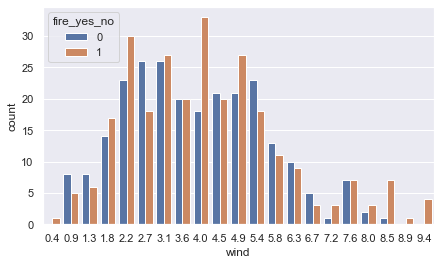

In [25]:
sns.set(rc={'figure.figsize':(7,4)})
sns.countplot(data=df, x='wind', hue='fire_yes_no')

In [26]:
df.groupby('fire_yes_no').median()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
fire_yes_no,,,,,,,,,,,
0,4,4,91.6,103.2,661.3,8.4,18.6,42,3.6,0.0,0.00
1,5,4,91.7,111.7,665.6,8.4,20.1,41,4.0,0.0,6.37


In [27]:
df.groupby('fire_yes_no').max()



,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
fire_yes_no,,,,,,,,,,,,,
0,9,9,sep,wed,96.2,290.0,855.3,56.1,32.4,100,8.5,1.0,0.00
1,9,9,sep,wed,96.2,291.3,860.6,22.7,33.3,96,9.4,6.4,1090.84


In [28]:
df.groupby('fire_yes_no').min()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
fire_yes_no,,,,,,,,,,,,,
0,1,2,apr,fri,18.7,1.1,7.9,0.0,4.2,15,0.9,0.0,0.00
1,1,2,apr,fri,63.5,3.2,15.3,0.8,2.2,15,0.4,0.0,0.09


<AxesSubplot:xlabel='month', ylabel='count'>

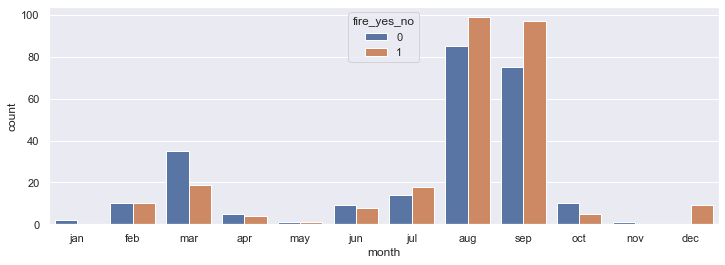

In [29]:
month=['jan', 'feb', 'mar', 'apr', 'may','jun', 'jul', 'aug','sep','oct', 'nov','dec']
sns.set(rc={'figure.figsize':(12,4)})
sns.countplot(data=df,x='month', order=month, hue='fire_yes_no')

<AxesSubplot:xlabel='day', ylabel='count'>

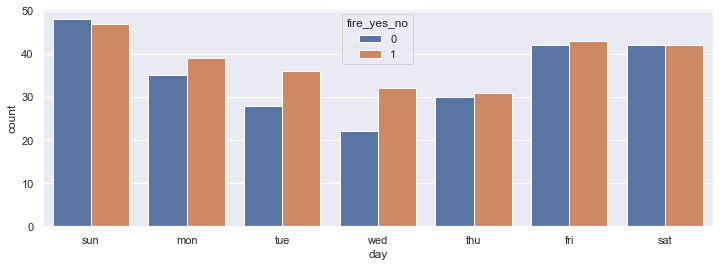

In [30]:
day=['sun', 'mon', 'tue', 'wed', 'thu','fri', 'sat']
sns.set(rc={'figure.figsize':(12,4)})
sns.countplot(data=df,x='day', order=day, hue='fire_yes_no')

`XXX`

### EDA: Uni / Multivariate Analysis

<AxesSubplot:>

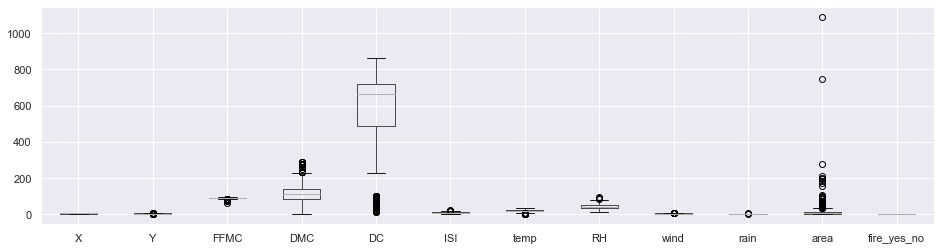

In [31]:
yes_fire.boxplot(figsize=(16,4))

<AxesSubplot:>

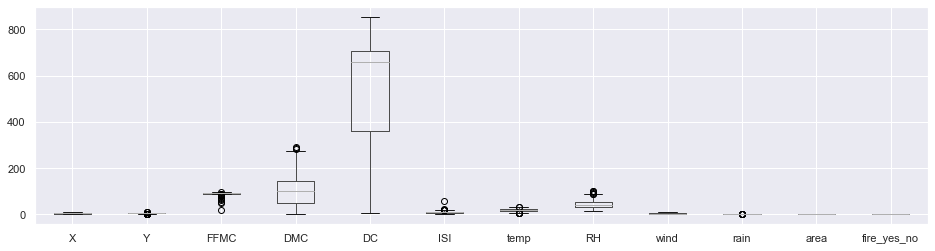

In [32]:
no_fire.boxplot(figsize=(16,4))

In [33]:
yes_fire.describe().T

,count,mean,std,min,25%,50%,75%,max
X,270.0,4.807407,2.383326,1.00,3.000,5.00,7.0000,9.00
Y,270.0,4.366667,1.170740,2.00,4.000,4.00,5.0000,9.00
FFMC,270.0,91.034074,3.709020,63.50,90.325,91.70,92.9750,96.20
DMC,270.0,114.707778,61.786520,3.20,82.900,111.70,141.3000,291.30
DC,270.0,570.867037,229.981242,15.30,486.500,665.60,721.3250,860.60
ISI,270.0,9.177037,4.147350,0.80,6.800,8.40,11.3750,22.70
temp,270.0,19.311111,6.179444,2.20,16.125,20.10,23.4000,33.30
RH,270.0,43.733333,15.080059,15.00,33.000,41.00,53.0000,96.00
wind,270.0,4.112963,1.884573,0.40,2.700,4.00,4.9000,9.40
rain,270.0,0.028889,0.398392,0.00,0.000,0.00,0.0000,6.40


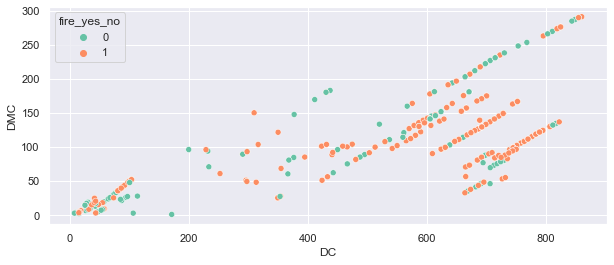

correlation between DC to DMC:  0.6821916119833171


In [34]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df['DC'], y=df['DMC'], hue=df['fire_yes_no'], palette='Set2') 
plt.show()

print('correlation between DC to DMC: ', df['DC'].corr(df['DMC']))

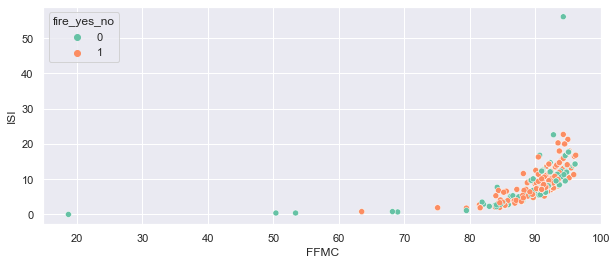

correlation between (FFMC) to (ISI):  0.5318049310435653


In [41]:
plt.rcParams['figure.figsize'] = (10, 4)
x=df['FFMC']
y=df['ISI']
sns.scatterplot(x=x, y=y, hue=df['fire_yes_no'], palette='Set2') 
plt.show()

print('correlation between (FFMC) to (ISI): ', df['FFMC'].corr(df['ISI']))

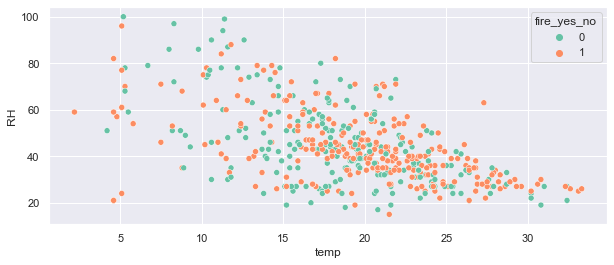

In [36]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df['temp'], y=df['RH'], hue=df['fire_yes_no'], palette='Set2') 
plt.show()

### Insights:

- XXX

### Feature Engineering

 - X and Y replace by sqrt(X^2+Y^2)
 - convert 'rain' into two categories
 - Features 'FFMC','ISI' and target 'area' for log transform
 - PCA to pile correlating features

In [42]:
df1=df.copy()

features_fl=['area', 'FFMC', 'ISI']

for i in features_fl:
                        
    df1[i+'_log']=np.log1p(df1[i])
    df1.drop(i, axis=1, inplace=True)
    
#sns.pairplot(df1, hue='fire_yes_no', height=3, aspect=1.7, palette='autumn_r')

In [43]:
df1['Z']=np.sqrt(df1['X']*df1['X']+df1['Y']*df1['Y'])
df1.drop(['X', 'Y'], axis=1, inplace=True)

#df1.head(3)

In [45]:
encoder = LabelEncoder()  

df1['DayId'] = encoder.fit_transform(df1.day) # returns label encoded variable(s)
df1['MonthId'] = encoder.fit_transform(df1.month) 

#df1.head(3)

In [46]:
df1.drop(['month', 'day'], axis=1, inplace=True)
df1.head(3)

,DMC,DC,temp,RH,wind,rain,fire_yes_no,area_log,FFMC_log,ISI_log,Z,DayId,MonthId
0,26.2,94.3,8.2,51,6.7,0.0,0,0.0,4.468204,1.808289,8.602325,0,7
1,35.4,669.1,18.0,33,0.9,0.0,0,0.0,4.517431,2.041220,8.062258,5,10
2,43.7,686.9,14.6,33,1.3,0.0,0,0.0,4.517431,2.041220,8.062258,2,10


<AxesSubplot:xlabel='area_log', ylabel='Count'>

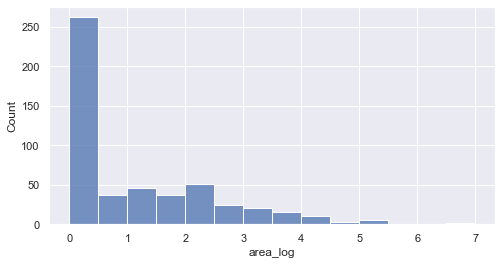

In [47]:
sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(data=df1, x='area_log')

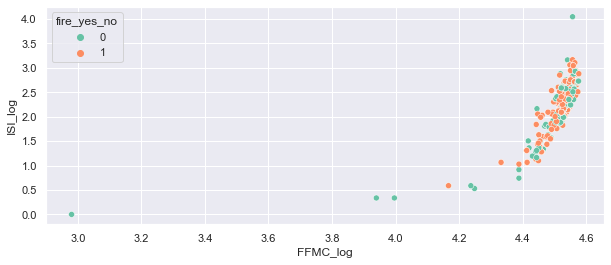

log correlation between ISI and FFMC is:  0.6433895940893903


In [48]:
# plt.rcParams['figure.figsize'] = (10, 4)
# sns.scatterplot(x=df['ISI'], y=df['FFMC'], hue=df['fire_yes_no'], palette='Set2') 
# plt.show()
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df1['FFMC_log'], y=df1['ISI_log'], hue=df1['fire_yes_no'], palette='Set2') 
plt.show()

print('log correlation between ISI and FFMC is: ', df1['FFMC_log'].corr(df1['ISI_log']))

In [57]:
# plt.rcParams['figure.figsize'] = (10, 4)
# ratio=df1['DMC']/(df1['DMC']+df1['DC'])
# sum_dmcdc = (df1['DMC']+df1['DC'])

# sns.scatterplot(x=df1['DMC'], y=sum_dmcdc, hue=df1['fire_yes_no'], palette='Set2') 
# plt.show()

# print('correlation between DMC to sum is: ', df1['DMC'].corr(sum_dmcdc))

In [58]:
# plt.rcParams['figure.figsize'] = (10, 4)

# ratio=df1['ISI_log']/(df1['ISI_log']+df1['FFMC_log'])
                      
# sns.scatterplot(x=df1['ISI_log'], y=ratio, hue=df1['fire_yes_no'], palette='Set2') 
# plt.show()

# print('correlation between ISI_log to FFMC_log: ', df1['ISI_log'].corr(ratio))

In [49]:
df1['rain_cat']=df1['rain'].apply(lambda x: 1 if x>0 else 0)
print(df1['rain'].value_counts(), df1['rain_cat'].value_counts())

0.0    509
0.8      2
0.2      2
0.4      1
6.4      1
1.4      1
1.0      1
Name: rain, dtype: int64 0    509
1      8
Name: rain_cat, dtype: int64


In [50]:
df1.drop(['rain', 'rain_cat'], axis=1, inplace=True)

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DMC          517 non-null    float64
 1   DC           517 non-null    float64
 2   temp         517 non-null    float64
 3   RH           517 non-null    int64  
 4   wind         517 non-null    float64
 5   fire_yes_no  517 non-null    int64  
 6   area_log     517 non-null    float64
 7   FFMC_log     517 non-null    float64
 8   ISI_log      517 non-null    float64
 9   Z            517 non-null    float64
 10  DayId        517 non-null    int64  
 11  MonthId      517 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 48.6 KB


In [231]:
#sns.pairplot(df1, hue='fire_yes_no', height=2, aspect=1, palette='winter')

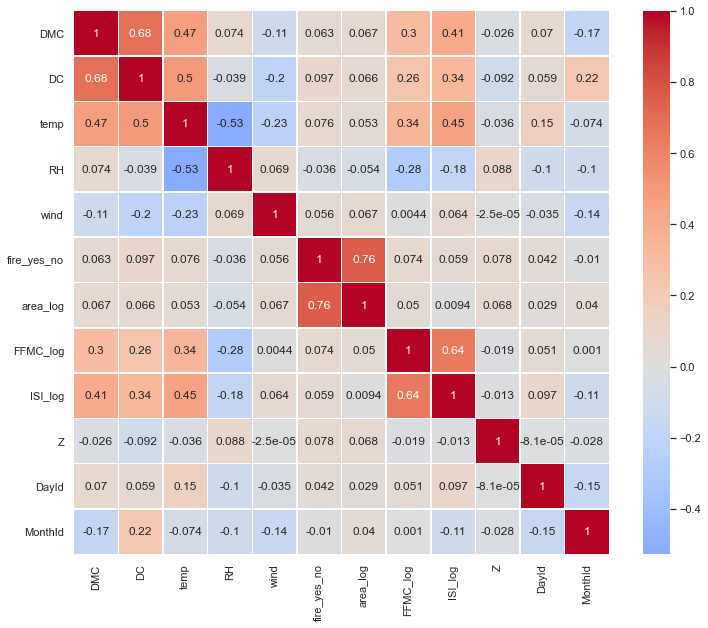

In [53]:
# Correlations heat map

sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df1.corr(),
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=True,
            cmap="coolwarm")
plt.show()

### Approach:

 - X and Y replace by sqrt(X^2+Y^2)
 - DMC + DC: convert to sum
 - ISI and FFMC to log, then convert to ratio
 - Perform Label Encoding to save number of input columns for month and day

In [54]:
# for i in list(df3.columns[df3.dtypes=='object']): 
    
#     df3[i]=df3[i].astype(int)

# df3.info()

In [55]:
Q1 = df1.quantile(q=0.25)
Q3 = df1.quantile(q=0.75)
IQR = Q3 - Q1
IQR

DMC             73.800000
DC             276.200000
temp             7.300000
RH              20.000000
wind             2.200000
fire_yes_no      1.000000
area_log         2.024193
FFMC_log         0.029175
ISI_log          0.453197
Z                3.062258
DayId            3.000000
MonthId         10.000000
dtype: float64

In [56]:
outliers = np.where((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR)))

print('% outliers in dataset is: ', round(len(outliers[0])/len(df1)*100, 1))

% outliers in dataset is:  30.0


### Insights:

 - Amount of outliers is only 6%. Not removing them because:
   - the dataset is relativelly small, so that it may bias the original data
   - it can decrease the model scores
   - there are non-normally distributed features in any case, so that Linear Regression likely is not the best option here, where Tree Regressors are not much sensitive to the outliers 

### Feature Engineering 

In [115]:
df2=df.copy()

df2['Z']=np.sqrt(df2['X']*df2['X']+df2['Y']*df2['Y'])
df2.drop(['X', 'Y'], axis=1, inplace=True)  

df2['DayId'] = encoder.fit_transform(df2.day) 
df2['MonthId'] = encoder.fit_transform(df2.month)

df2.drop(['month', 'day'], axis=1, inplace=True)
df2.head(3)

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,fire_yes_no,Z,DayId,MonthId
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,8.602325,0,7
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,8.062258,5,10
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,8.062258,2,10


In [131]:
FFMC_ISI_df = df2[['FFMC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'fire_yes_no']]
DMC_DC_df = df2[['DMC', 'DC', 'temp', 'RH', 'rain', 'fire_yes_no']]

In [122]:
FFMC_ISI_df.head()

,FFMC,ISI,temp,RH,wind,rain,fire_yes_no
0,86.2,5.1,8.2,51,6.7,0.0,0
1,90.6,6.7,18.0,33,0.9,0.0,0
2,90.6,6.7,14.6,33,1.3,0.0,0
3,91.7,9.0,8.3,97,4.0,0.2,0
4,89.3,9.6,11.4,99,1.8,0.0,0


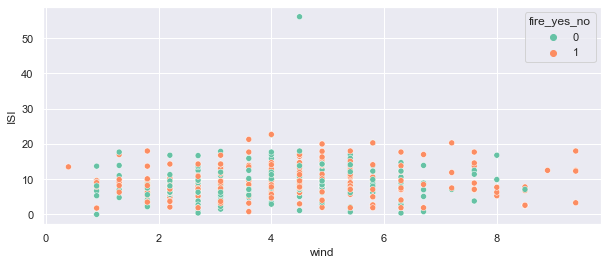

log correlation between ISI and wind is:  0.10682588792335049


In [126]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=FFMC_ISI_df['wind'], y=FFMC_ISI_df['ISI'], hue=FFMC_ISI_df['fire_yes_no'], palette='Set2') 
plt.show()

print('log correlation between ISI and wind is: ', FFMC_ISI_df['ISI'].corr(FFMC_ISI_df['wind']))

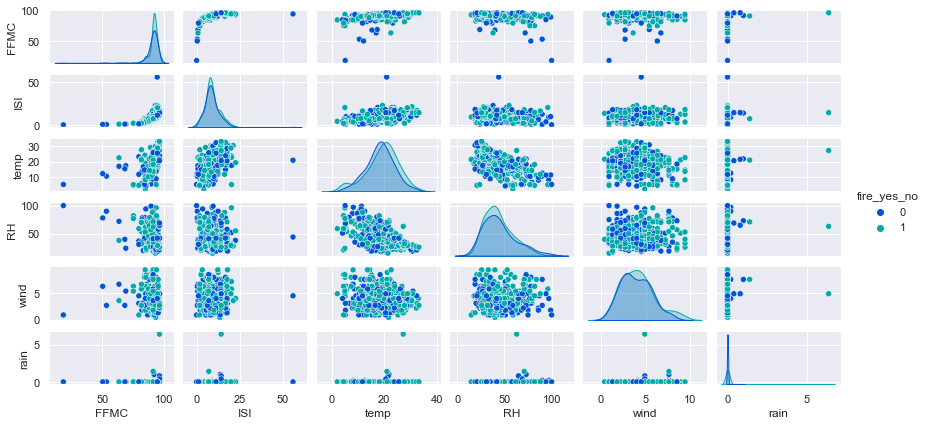

In [127]:
sns.pairplot(FFMC_ISI_df, hue='fire_yes_no', height=1, aspect=2, palette='winter')

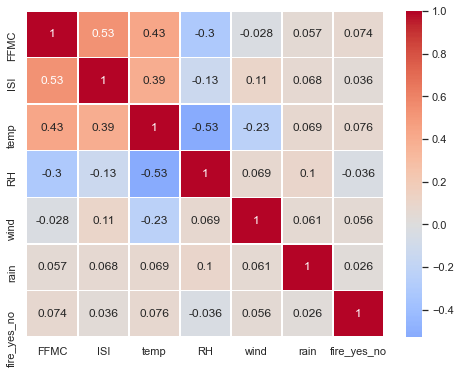

In [129]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(FFMC_ISI_df.corr(),
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=True,
            cmap="coolwarm")
plt.show()

In [132]:
df3=FFMC_ISI_df.copy()

features=['FFMC', 'ISI']

for i in features:
                        
    df3[i+'_log']=np.log1p(df3[i])
    df3.drop(i, axis=1, inplace=True)

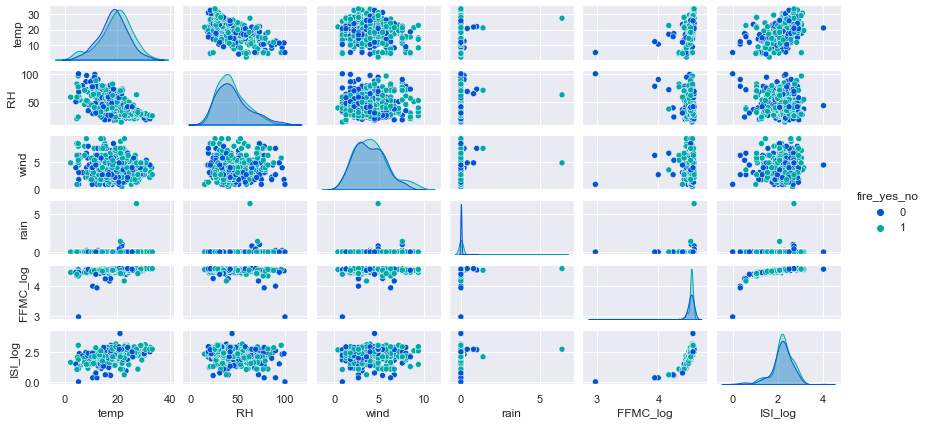

In [133]:
sns.pairplot(df3, hue='fire_yes_no', height=1, aspect=2, palette='winter')

In [134]:
df3['FFMC-ISI_logsum']=df3['FFMC_log']+df3['ISI_log']
df3.drop(['FFMC_log', 'ISI_log'], axis=1, inplace=True)

In [136]:
df3['RH_temp_ratio']=df3['RH']/df3['temp']

df3['RH_temp_ratio_log']=np.log1p(df3['RH_temp_ratio'])

df3.drop(['RH_temp_ratio', 'RH', 'temp'], axis=1, inplace=True)



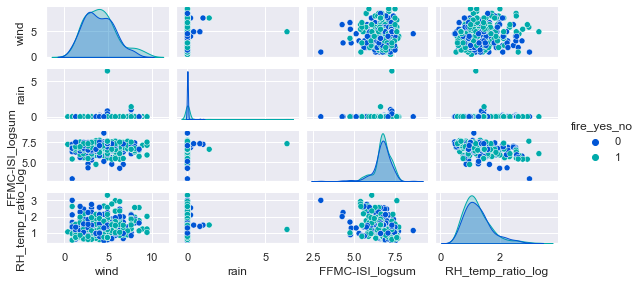

In [137]:
sns.pairplot(df3, hue='fire_yes_no', height=1, aspect=2, palette='winter')

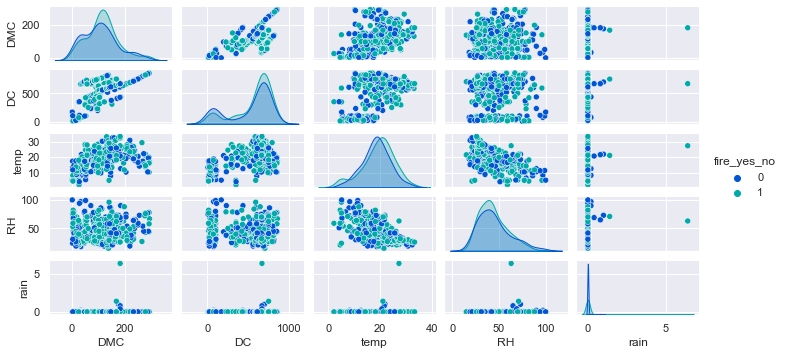

In [138]:
sns.pairplot(DMC_DC_df, hue='fire_yes_no', height=1, aspect=2, palette='winter')

In [139]:
df4=DMC_DC_df.copy()

df4['DMC_DC_ratio_log']=np.log1p(df1['DMC']/(df1['DMC']+df1['DC']))

df4.drop(['DMC', 'DC'], axis=1, inplace=True)

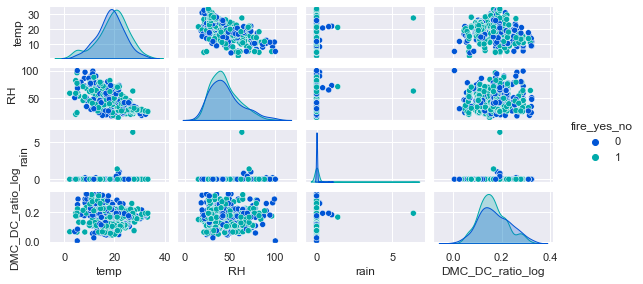

In [140]:
#ratio=df1['DMC']/(df1['DMC']+df1['DC'])

sns.pairplot(df4, hue='fire_yes_no', height=1, aspect=2, palette='winter')

In [175]:
df6=df2.copy()

df6['DMC_DC_ratio_log']=np.log1p(df6['DMC']/(df6['DMC']+df6['DC']))
df6['RH_temp_ratio']=np.log1p(df6['RH']/df6['temp']) 
df6['FFMC-ISI_logsum']=np.log1p(df6['FFMC'])+np.log1p(df6['ISI'])
df6['area_log']=np.log1p(df6['area'])

df6.drop(['FFMC', 'ISI', 'RH', 'temp', 'DMC', 'DC', 'rain', 'area'], axis=1, inplace=True)

df6.head()

,wind,fire_yes_no,Z,DayId,MonthId,DMC_DC_ratio_log,RH_temp_ratio,FFMC-ISI_logsum,area_log
0,6.7,0,8.602325,0,7,0.196740,1.976787,6.276493,0.0
1,0.9,0,8.062258,5,10,0.049027,1.041454,6.558652,0.0
2,1.3,0,8.062258,2,10,0.058093,1.181811,6.558652,0.0
3,4.0,0,10.000000,0,7,0.262781,2.540558,6.831954,0.0
4,1.8,0,10.000000,3,7,0.288333,2.270497,6.863991,0.0


/Users/innag/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


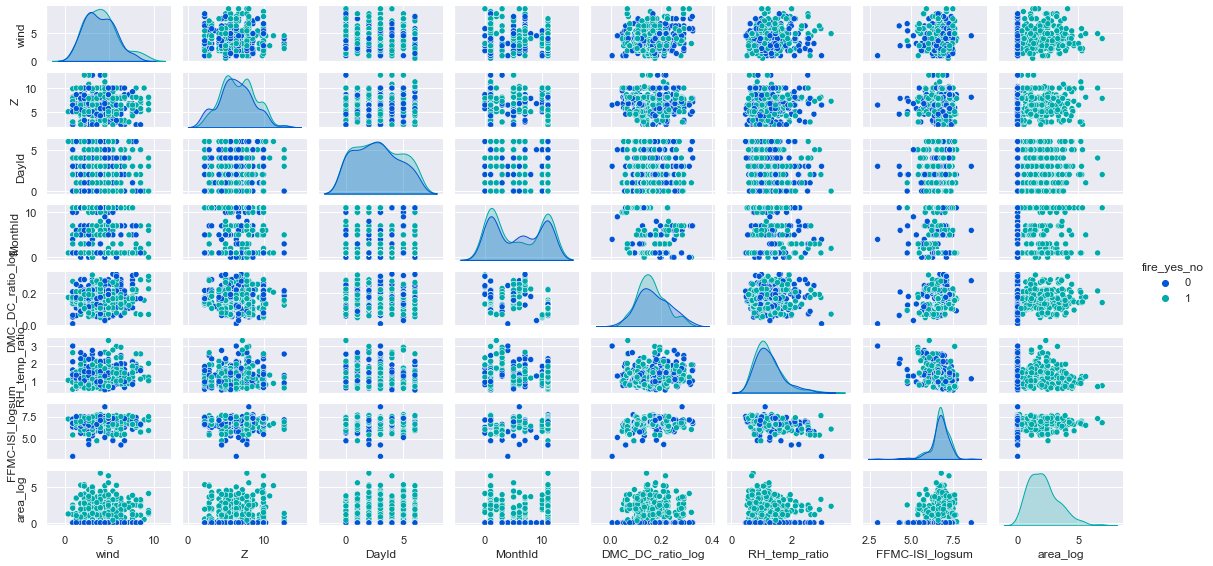

In [176]:
sns.pairplot(df6, hue='fire_yes_no', height=1, aspect=2, palette='winter')

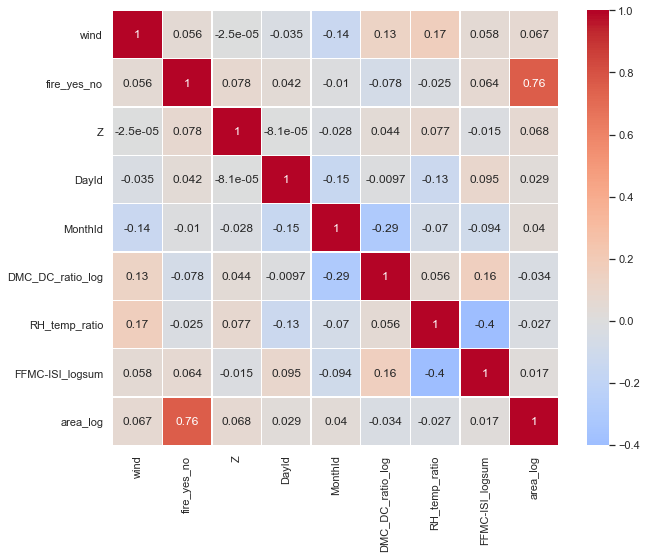

In [177]:
sns.set(rc={'figure.figsize':(10,8)})

sns.heatmap(df6.corr(),
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=True,
            cmap="coolwarm")
plt.show()

## Data Split and Scaling

In [178]:
print(df6.shape)

(517, 9)


### PCA to pile correlating features and reduce number of features

In [181]:
X = df6.drop(columns=['area_log', 'fire_yes_no'])  # Separating the target and the rest
y = df6.area_log

In [182]:
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area_log, dtype: float64

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 17733)

In [184]:
print('train data size', X_train.shape, y_train.shape)
print('test data size', X_test.shape, y_test.shape)

train data size (413, 7) (413,)
test data size (104, 7) (104,)


In [185]:
y_train1 = y_train.values.reshape(-1,1)
y_test1 = y_test.values.reshape(-1,1)

y_train1.shape

(413, 1)

In [186]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train1)

In [187]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train1)
y_test_scaled = y_scaler.transform(y_test1)

In [188]:
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y.values.reshape(-1,1))

In [189]:
X_train_scaled[0]

array([0.9       , 0.32604211, 0.16666667, 0.18181818, 0.18661328,
       0.43443002, 0.58189985])

### PCA 

In [190]:
# generating the covariance matrix and the eigen values for the PCA analysis
cov_matrix = np.cov(X_train_scaled.T) # the relevanat covariance matrix
print('Covariance Matrix \n%s', cov_matrix[0])

Covariance Matrix 
%s [ 0.0410859  -0.00025734 -0.00207837 -0.01413091  0.00451585  0.00610759
  0.00155104]


In [191]:
cov_matrix.shape

(7, 7)

In [192]:
#generating the eigen values and the eigen vectors
e_vals, e_vecs = np.linalg.eig(cov_matrix)
print('Eigenvectors first component \n%s' %e_vecs[0])
print('\nEigenvalues \n%s' %e_vals)

Eigenvectors first component 
[-0.10606308  0.1025101  -0.10707573  0.34263554 -0.04592999  0.92033432
  0.01591084]

Eigenvalues 
[0.17188819 0.09942368 0.00866205 0.02687813 0.03178817 0.04105511
 0.04478633]


In [193]:
# the "cumulative variance explained" analysis 
tot = sum(e_vals)
var_exp = [( i /tot ) * 100 for i in sorted(e_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [ 40.49366728  63.91604173  74.46686896  84.13869172  91.62739374
  97.95938194 100.        ]


In [194]:
var_exp

[40.49366727500455,
 23.422374454369084,
 10.550827235217215,
 9.671822754677436,
 7.488702021119257,
 6.3319882026951975,
 2.0406180569172547]

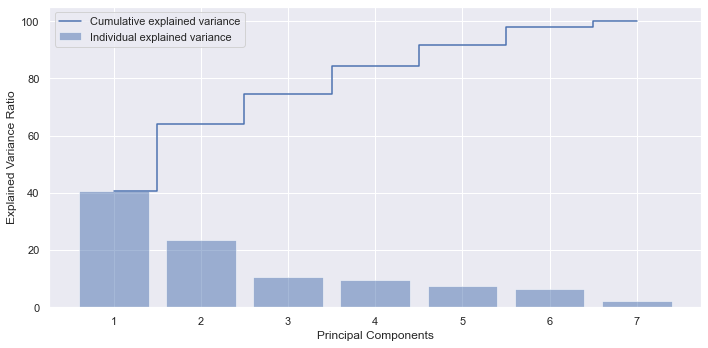

In [195]:
# Plotting the variance expalained by the principal components and the cumulative variance explained.
plt.figure(figsize=(10 , 5))
plt.bar(range(1, e_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, e_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [196]:
eigen_pairs = [(np.abs(e_vals[i]), e_vecs[:,i]) for i in range(len(e_vals))]
eigen_pairs.sort(reverse=True)
#eigen_pairs[:6]

In [197]:
len(eigen_pairs)

7

In [198]:
# generating dimensionally reduced datasets
w = np.hstack((eigen_pairs[0][1].reshape(7,1), 
                    eigen_pairs[1][1].reshape(7,1),
                   eigen_pairs[2][1].reshape(7,1),
                   eigen_pairs[3][1].reshape(7,1),
                   eigen_pairs[4][1].reshape(7,1),
                   eigen_pairs[5][1].reshape(7,1)
              ))
print('Matrix W:\n', w)

Matrix W:
 [[-0.10606308  0.1025101   0.01591084  0.92033432 -0.04592999  0.34263554]
 [-0.02542771  0.01907046  0.9852056  -0.0795541  -0.01572918  0.1463994 ]
 [-0.23691648 -0.9619568   0.03262035  0.10829323  0.01123071 -0.07453397]
 [ 0.948477   -0.21016128  0.04857312  0.15388359  0.17001592 -0.03048309]
 [-0.17532391  0.09024383  0.05851535  0.11279775  0.92735971 -0.28365386]
 [-0.02022356  0.10495736  0.14256587  0.31143627 -0.26796008 -0.7803109 ]
 [-0.03490787 -0.02096054 -0.04409371 -0.03914616  0.19186678  0.40661893]]


In [199]:
print(w.shape, X_train_scaled.shape)

(7, 6) (413, 7)


### Creating reduced shape for train data

In [200]:
X_train_scaled_pca = X_train_scaled.dot(w)
X_test_scaled_pca = X_test_scaled.dot(w)

In [201]:
print(X_train_scaled.shape, w.shape, X_train_scaled_pca.shape, X_test_scaled_pca.shape)

(413, 7) (7, 6) (413, 6) (104, 6)


In [202]:
df_pca=pd.DataFrame(X_test_scaled_pca).corr()

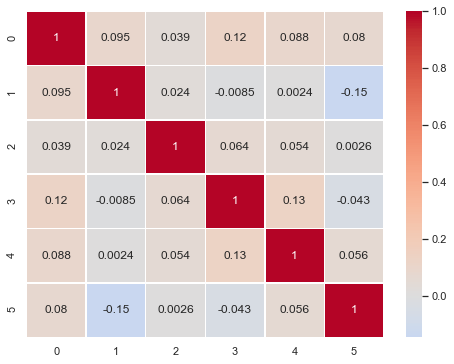

In [203]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(df_pca,
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=True,
            cmap="coolwarm")
plt.show()

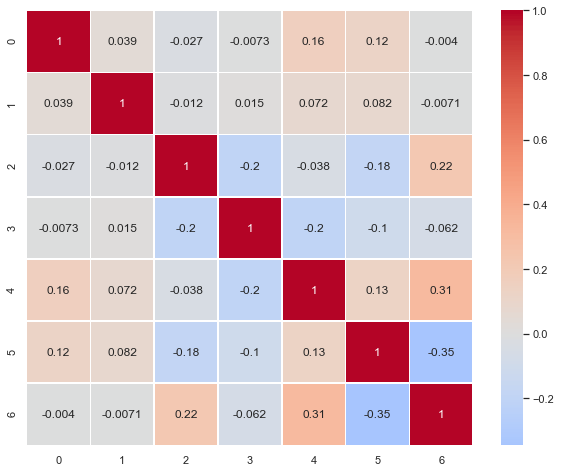

In [204]:
x_test_cor=pd.DataFrame(X_test_scaled).corr()

sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(x_test_cor,
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=True,
            cmap="coolwarm")
plt.show()

### Regressors  and Tuning

### Linear Regression

In [205]:
reg = LinearRegression(n_jobs=100)
reg_model=reg.fit(X_train_scaled_pca, y_train_scaled)

In [208]:
y_pred_lr = reg_model.predict(X_test_scaled_pca)

print('Training score: ', reg_model.score(X_train_scaled_pca, y_train_scaled))
print('Testing score: ', reg_model.score(X_test_scaled_pca, y_test_scaled))

Training score:  0.01569717324824149
Testing score:  0.008178394690321444


In [209]:
mean_absolute_error(y_test_scaled, y_pred_lr)

0.1631054103746374

In [210]:
lasso = Lasso(alpha=0.0001, random_state=28)
lasso.fit(X_train_scaled_pca, y_train_scaled)

print ("Lasso model:", (lasso.coef_))

Lasso model: [ 0.01236172 -0.03208745  0.04838526  0.06062179  0.          0.08590111]


In [211]:
print('Training score: ', lasso.score(X_train_scaled_pca, y_train_scaled))
print('Testing score: ', lasso.score(X_test_scaled_pca, y_test_scaled))

Training score:  0.015667403891267084
Testing score:  0.008711288795231975


### Polynomial model, degree 3

In [212]:
poly = PolynomialFeatures(degree=3, interaction_only=True)
X_train2 = poly.fit_transform(X_train_scaled_pca)
X_test2 = poly.fit_transform(X_test_scaled_pca)

poly_clf = linear_model.LinearRegression()

poly_clf.fit(X_train2, y_train_scaled)

y_pred = poly_clf.predict(X_test2)

In [213]:
print('Training score: ', poly_clf.score(X_train2, y_train_scaled))
print('Testing score: ', poly_clf.score(X_test2, y_test_scaled))

Training score:  -1.321972342281454
Testing score:  -1.4013138808263932


### Decision Tree

In [214]:
regressor_dt = DecisionTreeRegressor(random_state=245)

regressor_dt_model = regressor_dt.fit(X_train_scaled_pca, y_train_scaled.ravel())
#y_pred_dt = regressor_dt_model.predict(X_test_scaled_pca)

In [216]:
print('Training score: ', regressor_dt_model.score(X_train_scaled_pca, y_train_scaled.ravel()))
print('Testing score: ', regressor_dt_model.score(X_test_scaled_pca, y_test_scaled.ravel()))

Training score:  0.9941477691262695
Testing score:  -1.0136522638343255


In [217]:
mean_absolute_error(y_test_scaled.ravel(), y_pred_dt)

0.14435838828379635

In [218]:
regressor_dt_model = regressor_dt.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_dt = regressor_dt_model.predict(X_test_scaled)

print('Training score DT, no PCA: ', regressor_dt_model.score(X_train_scaled, y_train_scaled.ravel()))
print('Testing score DT, no PCA: ', regressor_dt_model.score(X_test_scaled, y_test_scaled.ravel()))

Training score DT, no PCA:  0.9941477691262695
Testing score DT, no PCA:  -0.7727147038272419


In [219]:
regressor_dt_model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [220]:
#DecisionTreeRegressor?

In [221]:
params={'criterion':['mse','mae', 'friedman_mse'],
        'splitter':['best', 'random'],
        'max_depth': [3, 5, 10],
        'max_features': ["auto", "sqrt", "log2"],
        'min_impurity_decrease':[0.0001, 0.001, 0.01]
}

In [170]:
#GridSearchCV?

In [222]:
grid = GridSearchCV(regressor_dt, params, cv=3, verbose=0)
grid.fit(X_train_scaled, y_train_scaled.ravel())

print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0.001, 'splitter': 'random'}
-0.013579043730626905


### Ranfom Forest Regressor

In [224]:
rf=RandomForestRegressor(random_state=447)

rf_model=rf.fit(X_train_scaled_pca, y_train_scaled.ravel())

y_pred_rf=rf_model.predict(X_test_scaled_pca)

In [225]:
print('Training score: ', rf_model.score(X_train_scaled_pca, y_train_scaled.ravel()))
print('Testing score: ', rf_model.score(X_test_scaled_pca, y_test_scaled.ravel()))

Training score:  0.8427249673632797
Testing score:  -0.09727059243190017


In [226]:
rf_model=rf.fit(X_train_scaled, y_train_scaled.ravel())

y_pred_rf=rf_model.predict(X_test_scaled)
print('Training score RF, no PCA: ', rf_model.score(X_train_scaled, y_train_scaled.ravel()))
print('Testing score: RF, no PCA', rf_model.score(X_test_scaled, y_test_scaled.ravel()))

Training score RF, no PCA:  0.8491474736952658
Testing score: RF, no PCA -0.1874165969376307


In [227]:
br=BaggingRegressor(random_state=447)

br_model=br.fit(X_train_scaled_pca, y_train_scaled.ravel())
y_pred_br=br_model.predict(X_test_scaled_pca)

In [228]:
print('Training score: ', br_model.score(X_train_scaled_pca, y_train_scaled.ravel()))
print('Testing score: ', br_model.score(X_test_scaled_pca, y_test_scaled.ravel()))

Training score:  0.7888157491729326
Testing score:  -0.18602191868213236


In [229]:
gbr=GradientBoostingRegressor(random_state=447)

gbr_model=gbr.fit(X_train_scaled_pca, y_train_scaled.ravel())

y_pred_gbr=gbr_model.predict(X_test_scaled_pca)

print('Training score: ', gbr_model.score(X_train_scaled_pca, y_train_scaled.ravel()))
print('Testing score: ', gbr_model.score(X_test_scaled_pca, y_test_scaled.ravel()))

Training score:  0.6330259507073026
Testing score:  -0.08086868973267447


In [230]:
#Without PCA

gbr=GradientBoostingRegressor(random_state=447)

gbr_model=gbr.fit(X_train_scaled, y_train_scaled.ravel())

y_pred_gbr=gbr_model.predict(X_test_scaled)

print('Training score: ', gbr_model.score(X_train_scaled, y_train_scaled.ravel()))
print('Testing score: ', gbr_model.score(X_test_scaled, y_test_scaled.ravel()))

Training score:  0.568465573277443
Testing score:  -0.2380929063624957


### Insights:

 - XXX.

## Conculsions